# Black-Scholes Autodifferentiation Example
In this example we are calculating $\theta$ values using the Black-Scholes model.

In [1]:
# Imports & Constants
import tributary.lazy as tl
import tributary.streaming as ts
import math
import matplotlib.pyplot as plt
import asyncio
TRADING_DAYS = 252

## We can use the tributary $\textit{Erf}$ operator to define a Standard Normal CDF
The CDF is defined using $\Phi(x, \mu, \sigma) = \frac{1}{2}\left(1 + Erf\left(\frac{x-\mu}{\sigma\sqrt{2}}\right)\right)$ for $\mu = 0, \sigma = 1$

In [2]:
# Lazy
def normal_cdf_lazy(x):
    return tl.Div(
        tl.Add(
            tl.Erf(tl.Div(x, (math.sqrt(2),0))), 
            (1,0)
        ),
        tl.Node((2,0), use_dual=True)
    )

# Streaming
def normal_cdf_streaming(x):
    return ts.Div(
                ts.Add(
                    ts.Erf(ts.Div(x, ts.Const((math.sqrt(2),0), use_dual=True))), 
                    ts.Const((1,0), use_dual=True)
                ),
                ts.Const((2,0), use_dual=True)
            )


## Now we can define our streams
For this example we are going use a Call Option.
We define the model as follows:

$C_p = S\Phi(d_1) - Xe^{-rt}\Phi(d_2)$

$d_1 = \frac{ln\left(\frac{S}{X}\right) + \left(r + \frac{\sigma^2}{2}\right)t}{\sigma\sqrt{t}}$

$d_2 = d_1 - \sigma\sqrt{t}$

Where

$C_p$ - Price of Call Option

$S$ - Stock Price

$X$ - Strike Price

$r$ - Risk Free Interest Rate

$\sigma$ - Stock Price Volatility

$t$ - Time to Maturity

$\Phi$ - Standard Normal CDF (defined above)

### Lazy Graph

In [3]:
strike_price = tl.Node(value=(203, 0), name='Strike Price', use_dual=True)
stock_price = tl.Node(value=(210, 0), name='Stock Price', use_dual=True)
r = tl.Node(value=(0.2175, 0), name='Risk Free Interest Rate', use_dual=True)
time = tl.Div(
              tl.Node(value=(4, 1), name='Time to Maturity', use_dual=True), 
              tl.Node(value=(TRADING_DAYS,0), use_dual=True)
        )
vol = tl.Node(value=(14.04, 0), name='Stock Price Volatility', use_dual=True)

d1 = tl.Div(
            tl.Add(
                tl.Log(tl.Div(stock_price,strike_price)),
                tl.Mult(time, 
                        tl.Add(r, 
                               tl.Div(tl.Pow(vol,2),
                                      tl.Node((2,0), use_dual=True)
                                )
                        )
                )
            ),
            tl.Mult(vol, tl.Sqrt(time))
    )

d2 = tl.Sub(d1, tl.Mult(vol, tl.Sqrt(time)))

opt_price_lazy = tl.Sub(
                        tl.Mult(
                                stock_price, 
                                normal_cdf_lazy(d1)
                        ),
                        tl.Mult(
                                strike_price, 
                                tl.Mult(
                                        tl.Exp(tl.Negate(tl.Mult(r,time))),
                                        normal_cdf_lazy(d2)
                                )
                        )
                )


In [4]:
# Run it
opt_price_lazy()

(132.41454517196362, 12.327192918542838)

### Streaming Graph

In [5]:
def _time():
    for _ in [1, 2, 3, 4, 5, 6, 7]:
        yield (_, 1)

strike_price = ts.Const((203,0), use_dual=True)
stock_price = ts.Const((210,0), use_dual=True)
r = ts.Const((0.2175, 0), use_dual=True)
time = ts.Div(
              ts.Node(foo=_time, name='Time', use_dual=True), 
              ts.Const((TRADING_DAYS,0), use_dual=True)
        )
vol = ts.Const((14.04, 0), use_dual=True)
   

d1 = ts.Div(
            ts.Add(
                   ts.Log(ts.Div(stock_price, strike_price)),
                   ts.Mult(
                           time, 
                           ts.Add(
                                  r, 
                                  ts.Div(
                                         ts.Pow(vol,2),
                                         ts.Const((2,0), use_dual=True)
                                  )
                            )
                  )
            ),
            ts.Mult(vol, ts.Sqrt(time))
     )

d2 = ts.Sub(d1, ts.Mult(vol, ts.Sqrt(time)))

opt_price_streaming = ts.Sub(
                   ts.Mult(stock_price, normal_cdf_streaming(d1)),
                   ts.Mult(
                           strike_price,
                           ts.Mult(
                                   ts.Exp(ts.Negate(ts.Mult(r,time))),
                                          normal_cdf_streaming(d2)
                           )
                    )
            )

In [6]:
# Run It
out_streaming = ts.run(opt_price_streaming)
while not out_streaming.done():
    await asyncio.sleep(1)

## Let's do some plots

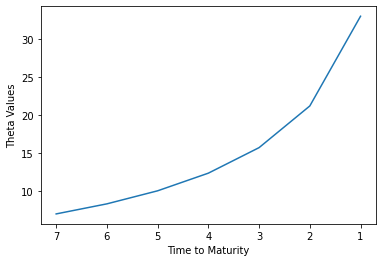

In [7]:
thetas = [x[1] for x in out_streaming.result()]
plt.plot([x[0] for x in _time()], thetas)
plt.xlabel('Time to Maturity')
plt.ylabel('Theta Values')
plt.gca().invert_xaxis()

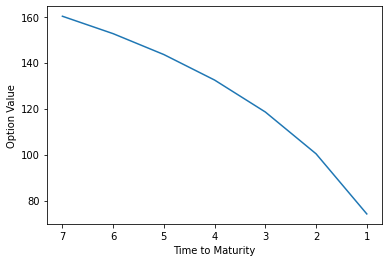

In [8]:
option_value = [x[0] for x in out_streaming.result()]
plt.plot([x[0] for x in _time()], option_value)
plt.xlabel('Time to Maturity')
plt.ylabel('Option Value')
plt.gca().invert_xaxis()